In [1]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, Birch
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import time
%matplotlib inline

In [2]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))
    
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    # y = emb_array[sample_number]
    # emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

def trainFisherWithNum(emb_array, sample_number):    
    y = emb_array[sample_number]
    emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w   

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [3]:
sess = tf.Session()
data_set = facenet.get_dataset("../../datasets/lfw/lfw_mtcnnpy_160/")
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)
load_model("20170511-185253", sess)

images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [4]:
emb_array = forward(train_paths, 100) # 100 means 100 mini-batches

batch number: 0
batch number: 1
batch number: 2
batch number: 3
batch number: 4
batch number: 5
batch number: 6
batch number: 7
batch number: 8
batch number: 9
batch number: 10
batch number: 11
batch number: 12
batch number: 13
batch number: 14
batch number: 15
batch number: 16
batch number: 17
batch number: 18
batch number: 19
batch number: 20
batch number: 21
batch number: 22
batch number: 23
batch number: 24
batch number: 25
batch number: 26
batch number: 27
batch number: 28
batch number: 29
batch number: 30
batch number: 31
batch number: 32
batch number: 33
batch number: 34
batch number: 35
batch number: 36
batch number: 37
batch number: 38
batch number: 39
batch number: 40
batch number: 41
batch number: 42
batch number: 43
batch number: 44
batch number: 45
batch number: 46
batch number: 47
batch number: 48
batch number: 49
batch number: 50
batch number: 51
batch number: 52
batch number: 53
batch number: 54
batch number: 55
batch number: 56
batch number: 57
batch number: 58
batch n

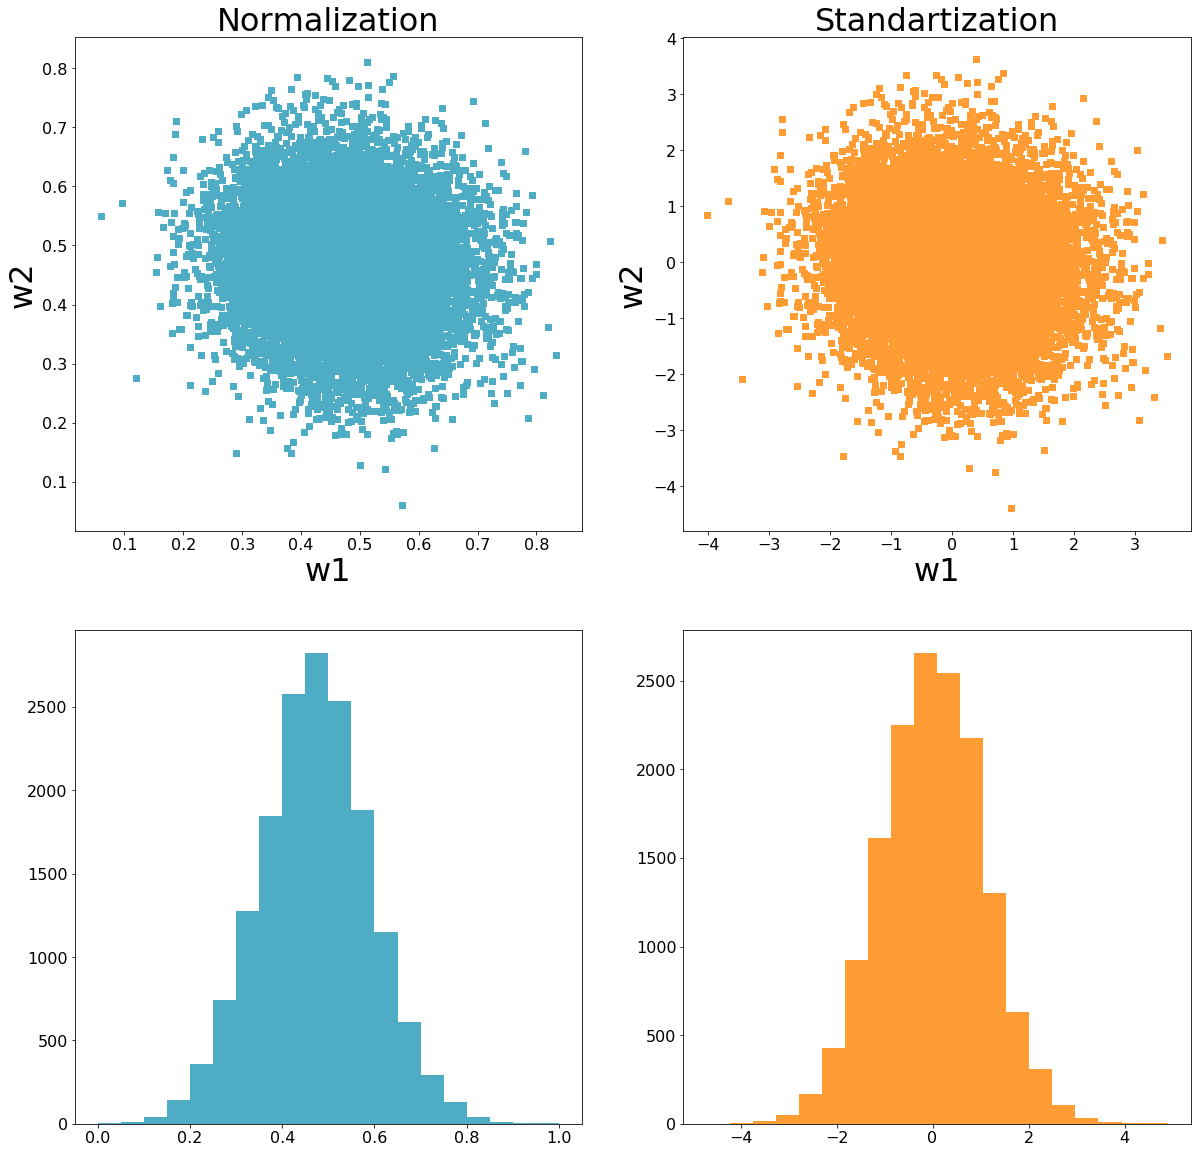

In [36]:
t = emb_array
w1 = 0
w2 = 1

colors = ['#4EACC5', '#FF9C34', '#4E9A06']
markers = ['s', '^', 'x']

plt.rcParams.update({'font.size': 16, 'axes.titlesize': 32, 'axes.labelsize': 32})

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
s_ = 0.01

# Centering
tc = t - np.mean(t, axis=0)

# Normalization
tn = (tc - tc.min()) / (tc.max() - tc.min())
ax1.scatter(tn[:, w1], tn[:, w2], s=32, marker=markers[0], c=colors[0])
ax1.set_title("Normalization", fontsize=32)
ax1.set_xlabel("w1", fontsize=32)
ax1.set_ylabel("w2", fontsize=32)

# Standartization
ts = tc / tc.std(axis=0)
ax2.scatter(ts[:, w1], ts[:, w2], s=32, marker=markers[0], c=colors[1])
ax2.set_title("Standartization", fontsize=32)
ax2.set_xlabel("w1", fontsize=32)
ax2.set_ylabel("w2", fontsize=32)

# Histograms
n, bins, rectangles = ax3.hist(tn, bins=20, facecolor=colors[0], histtype="stepfilled")
n, bins, rectangles = ax4.hist(ts, bins=20, facecolor=colors[1], histtype="stepfilled")

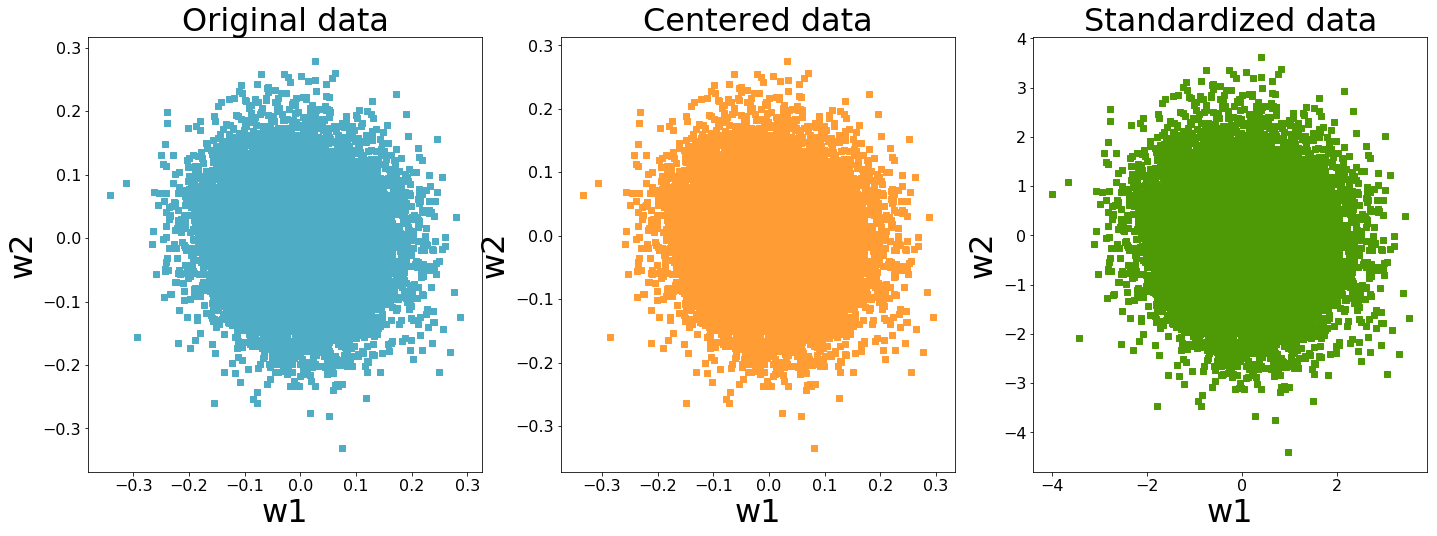

In [41]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

# Original data
ax1.set_title("Original data")
ax1.scatter(t[:, w1], t[:, w2], s=32, marker=markers[0], c=colors[0])
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")

# Centered data
ax2.set_title("Centered data")
ax2.scatter(tc[:, w1], tc[:, w2], s=32, marker=markers[0], c=colors[1])
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# Standardized data
ax3.set_title("Standardized data")
ax3.scatter(ts[:, w1], ts[:, w2], s=32, marker=markers[0], c=colors[2])
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

#plt.savefig('plots/preprocess.png')

In [7]:
males = np.loadtxt("male_names.txt", dtype=str)
females = np.loadtxt("female_names.txt", dtype=str)

for i in range(len(males)):
    males[i] = males[i].replace(".jpg", ".png")
for i in range(len(females)):
    females[i] = females[i].replace(".jpg", ".png")
    
names = []
for i in range(len(train_paths)):
    names.append(train_paths[i].split("\\")[-1])
names = np.asarray(names) # from list to ndarray

indx_males = np.in1d(names, males)
indx_females = np.in1d(names, females)

Everything ok!


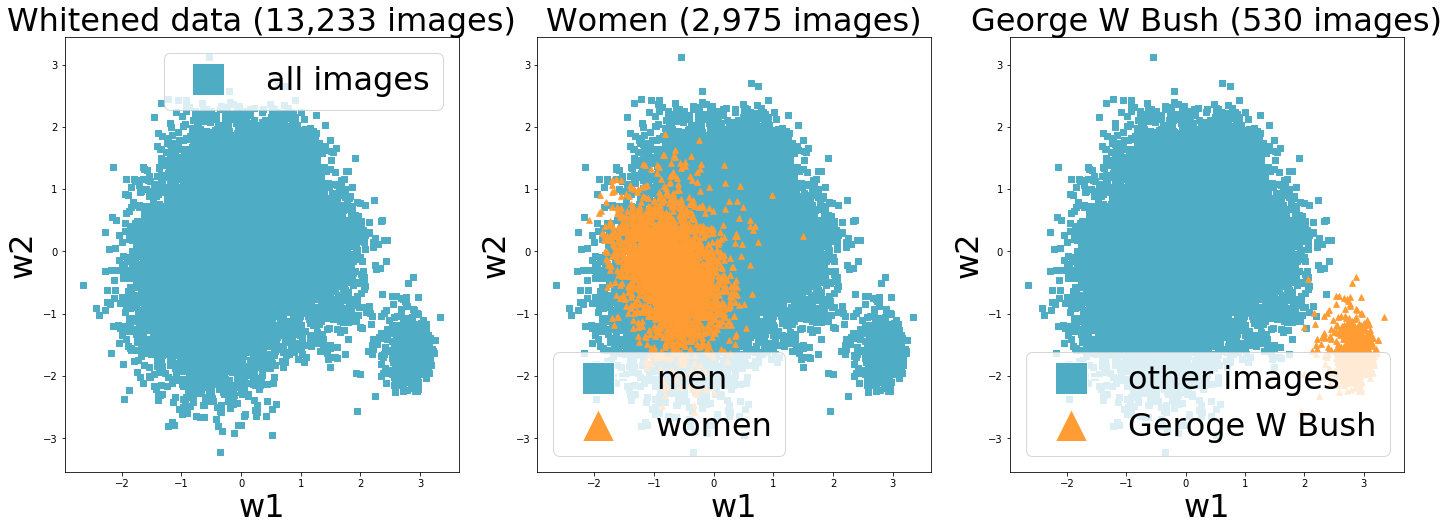

In [8]:
# Current working matrix
X = ts

cov = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov)

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

pca_matrix = eig_pairs[0][1].reshape(128, 1)
num_components = 50

for i in range(1, num_components):
    pca_matrix = np.hstack((pca_matrix,
                            eig_pairs[i][1].reshape(128, 1)))

X_pca = X.dot(pca_matrix)

# Whitening
X_whit = X_pca / np.sqrt(eig_vals[:num_components])

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

w1 = 0
w2 = 1

colors = ['#4EACC5', '#FF9C34', '#4E9A06']
markers = ['s', '^', 'x']

# Whitened data
ax1.set_title("Whitened data (13,233 images)", fontsize=32)
ax1.scatter(X_whit[:, w1], X_whit[:, w2], c=colors[0], marker=markers[0], s=32)
ax1.set_xlabel("w1", fontsize=32)
ax1.set_ylabel("w2", fontsize=32)
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="all images")
ax1.legend(handles=[c1_patch], fontsize=32)

X_male = X_whit[indx_males]
X_female = X_whit[indx_females]

ax2.set_title("Women (2,975 images)", fontsize=32)
ax2.scatter(X_male[:, w1], X_male[:, w2], marker=markers[0], s=32, c=colors[0])
ax2.scatter(X_female[:, w1], X_female[:, w2], marker=markers[1], s=32, c=colors[1])
ax2.set_xlabel("w1", fontsize=32)
ax2.set_ylabel("w2", fontsize=32)

c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="men")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="women")
ax2.legend(handles=[c1_patch, c2_patch], fontsize=32)

train_labels = np.asarray(train_labels)
train_paths = np.asarray(train_paths)
X_left = X_whit[:, w1] > 2.5 # just for example (for finding train_labels)
Bush = X_whit[train_labels == 1871]

ax3.set_title("George W Bush (530 images)", fontsize=32)
ax3.scatter(X_whit[train_labels != 1871, w1], X_whit[train_labels != 1871, w2], c=colors[0], s=32, marker=markers[0])
ax3.scatter(Bush[:, w1], Bush[:, w2], c=colors[1], s=32, marker=markers[1])
ax3.set_xlabel("w1", fontsize=32)
ax3.set_ylabel("w2", fontsize=32)

c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="other images")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="Geroge W Bush")
ax3.legend(handles=[c1_patch, c2_patch], fontsize=32)

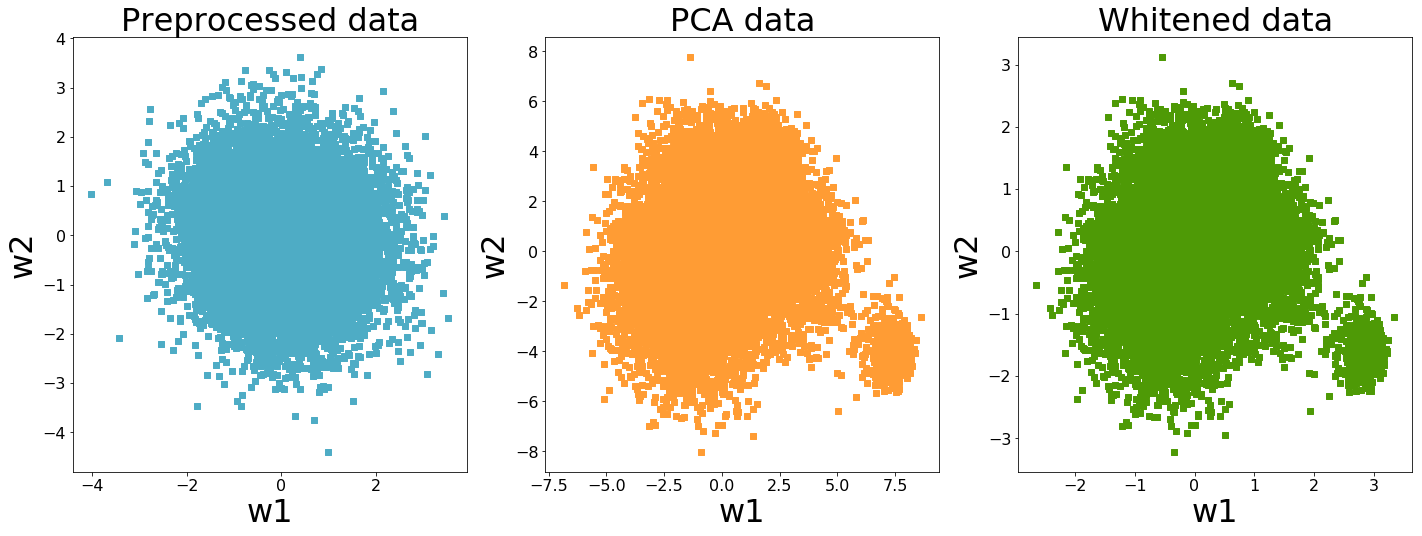

In [44]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

# Original data
ax1.set_title("Preprocessed data")
ax1.scatter(X[:, w1], X[:, w2], s=32, marker=markers[0], c=colors[0])
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")

# PCA data
ax2.set_title("PCA data")
ax2.scatter(X_pca[:, w1], X_pca[:, w2], s=32, marker=markers[0], c=colors[1])
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# Whitened data
ax3.set_title("Whitened data")
ax3.scatter(X_whit[:, w1], X_whit[:, w2], s=32, marker=markers[0], c=colors[2])
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

#plt.savefig('plots/whitening.png')

Text(0,0.5,'w2')

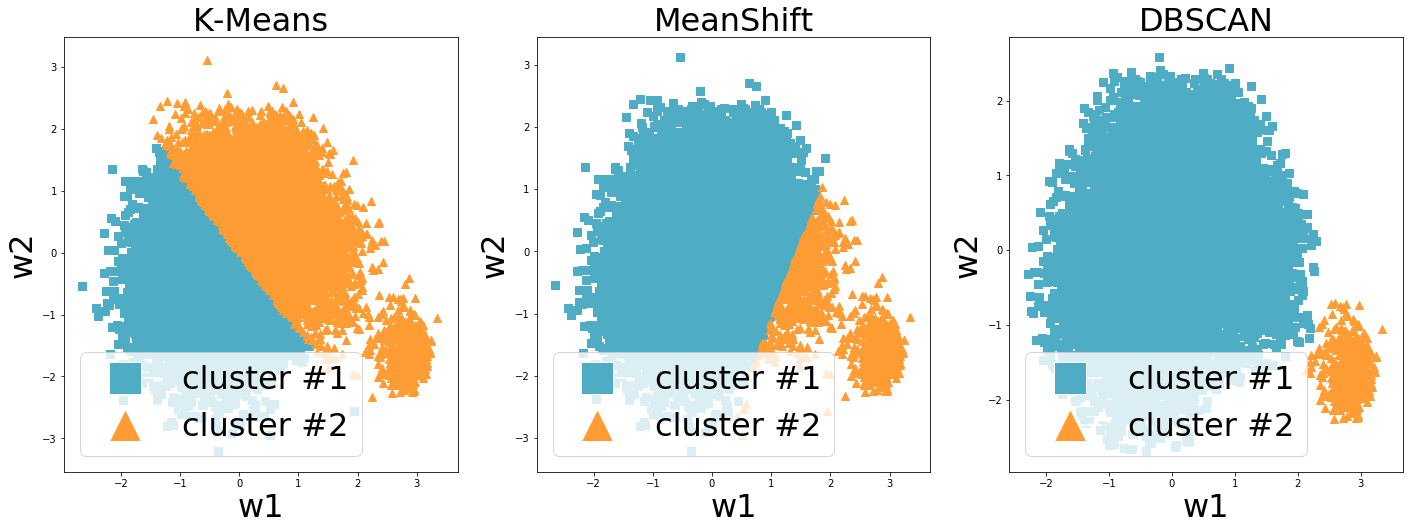

In [9]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
markers = ['s', '^', 'x']
n_clusters = 2



fit = KMeans(n_clusters=n_clusters).fit(X_whit[:, 0:2])
c = fit.predict(X_whit[:, 0:2])
clr = 0
for clt in range(n_clusters):
    ax1.scatter(X_whit[c == clt, w1], X_whit[c == clt, w2], c=colors[clr], s=64, marker=markers[clr])
    clr += 1
ax1.set_title("K-Means", fontsize=32)
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="cluster #1")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="cluster #2")
ax1.legend(handles=[c1_patch, c2_patch], prop={'size': 32})
ax1.set_xlabel("w1", fontsize=32)
ax1.set_ylabel("w2", fontsize=32)



bandwidth = estimate_bandwidth(X_whit[:, 0:2], quantile=0.3, n_samples=400)
fit = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_whit[:, 0:2])
c = fit.predict(X_whit[:, 0:2])
clr = 0
for clt in range(n_clusters):
    ax2.scatter(X_whit[c == clt, w1], X_whit[c == clt, w2], c=colors[clr], s=64, marker=markers[clr])
    clr += 1
ax2.set_title("MeanShift", fontsize=32)
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="cluster #1")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="cluster #2")
ax2.legend(handles=[c1_patch, c2_patch], prop={'size': 32})
ax2.set_xlabel("w1", fontsize=32)
ax2.set_ylabel("w2", fontsize=32)



fit = DBSCAN(eps=0.3, min_samples=30).fit(X_whit[:, 0:2])
c = fit.labels_
clr = 0
for clt in range(n_clusters):
    ax3.scatter(X_whit[c == clt, w1], X_whit[c == clt, w2], c=colors[clr], s=64, marker=markers[clr])
    clr += 1
ax3.set_title("DBSCAN", fontsize=32)
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="cluster #1")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="cluster #2")
ax3.legend(handles=[c1_patch, c2_patch], prop={'size': 32})
ax3.set_xlabel("w1", fontsize=32)
ax3.set_ylabel("w2", fontsize=32)

#plt.savefig('plots/2_params.png')

Text(0,0.5,'w2')

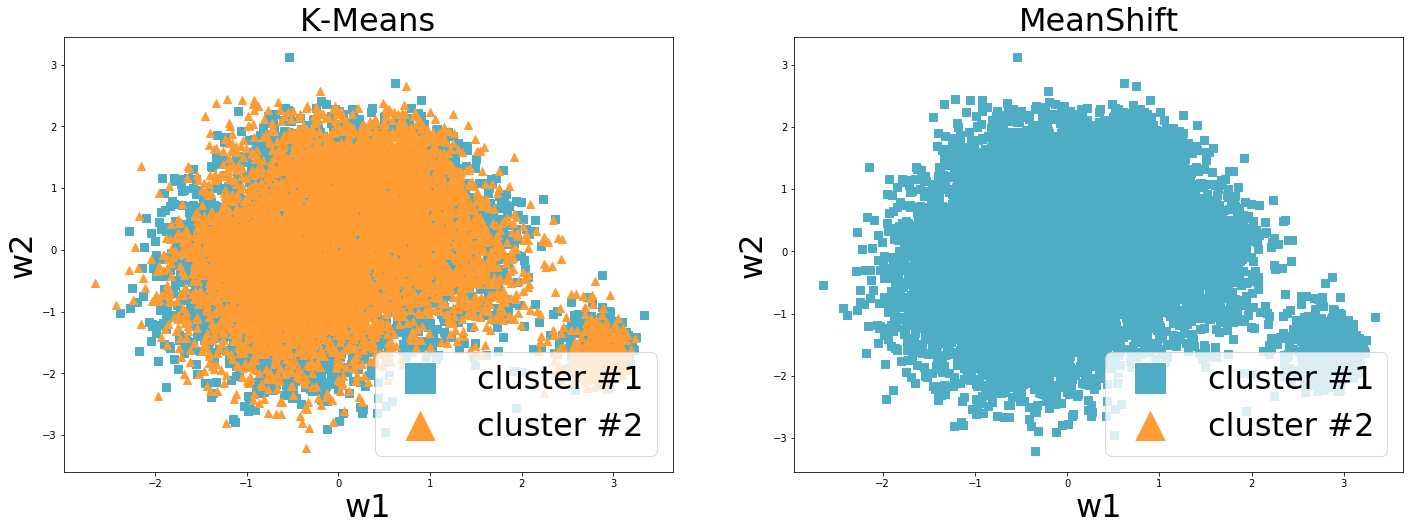

In [10]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
markers = ['s', '^', 'x']
n_clusters = 2



fit = KMeans(n_clusters=n_clusters).fit(X_whit)
c = fit.predict(X_whit)
clr = 0
for clt in range(n_clusters):
    ax1.scatter(X_whit[c == clt, w1], X_whit[c == clt, w2], c=colors[clr], s=64, marker=markers[clr])
    clr += 1
ax1.set_title("K-Means", fontsize=32)
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="cluster #1")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="cluster #2")
ax1.legend(handles=[c1_patch, c2_patch], prop={'size': 32})
ax1.set_xlabel("w1", fontsize=32)
ax1.set_ylabel("w2", fontsize=32)



bandwidth = estimate_bandwidth(X_whit, quantile=0.3, n_samples=400)
fit = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_whit)
c = fit.predict(X_whit)
clr = 0
for clt in range(n_clusters):
    ax2.scatter(X_whit[c == clt, w1], X_whit[c == clt, w2], c=colors[clr], s=64, marker=markers[clr])
    clr += 1
ax2.set_title("MeanShift", fontsize=32)
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="cluster #1")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="cluster #2")
ax2.legend(handles=[c1_patch, c2_patch], prop={'size': 32})
ax2.set_xlabel("w1", fontsize=32)
ax2.set_ylabel("w2", fontsize=32)

#plt.savefig('plots/all_params.png')

NameError: name 'centres' is not defined

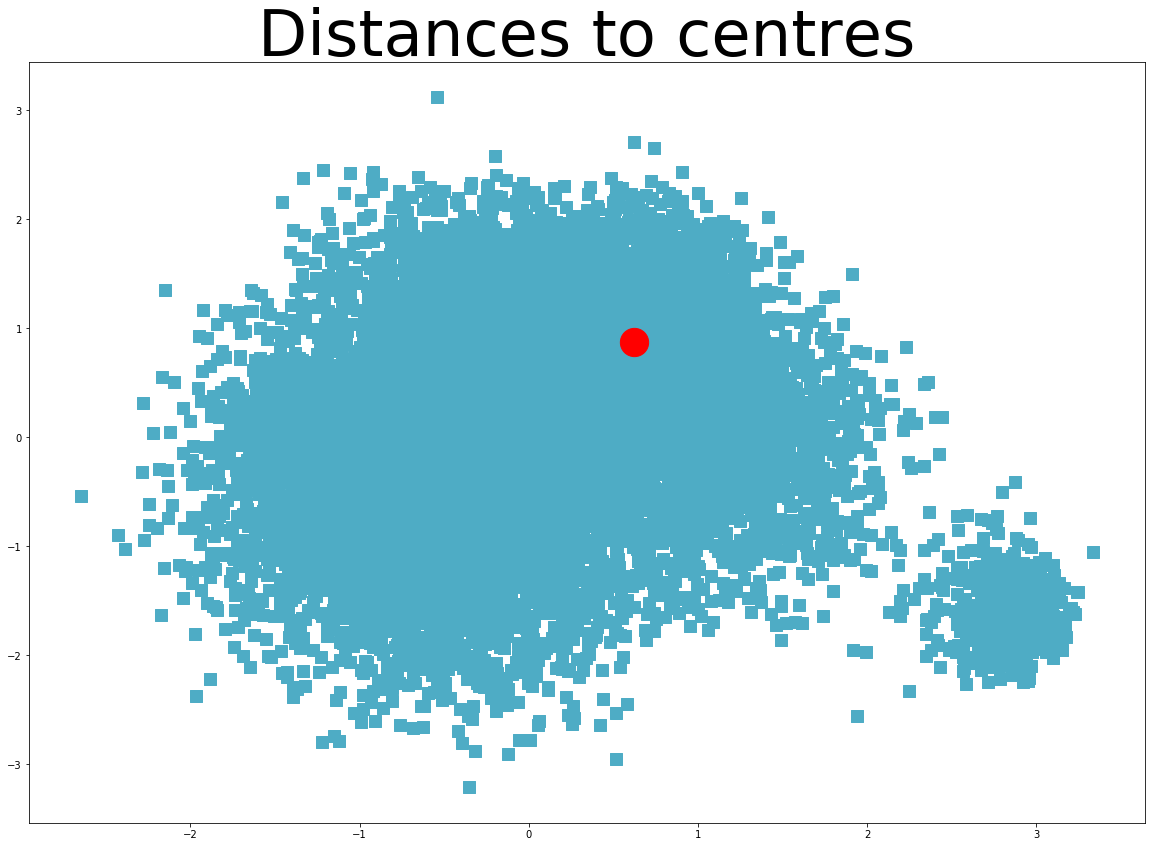

In [11]:
plt.figure(figsize=(20,14))
plt.title("Distances to centres", fontsize=64)
clr = 0
for clt in range(n_clusters):
    plt.scatter(X_whit[c == clt, w1], X_whit[c == clt, w2], c=colors[clr], s=128, marker=markers[clr])
    clr += 1
plt.scatter(X_whit[159, w1], X_whit[159, w2], c="red", s=800)
area = 4 * np.pi * (3 * 2)**2
colors_centres=["red", "green", "blue"]
markers_centres=['p', '*']
for i in range(n_clusters):
    mask = (c == i)
    km = KMeans(n_clusters=1).fit(X_whit[mask])
    cx = km.cluster_centers_[0, 0]
    cy = km.cluster_centers_[0, 1]
    centres.append((cx, cy))
    plt.scatter(cx, cy, color="green", marker="*", s=1000)
    plt.plot([cx, point_x], [cy, point_y], c='red')
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="cluster #1")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="cluster #2")
c3_patch = plt.Line2D(range(1), range(1), color="white", marker='o', markersize=32, markerfacecolor="red", label="new point (new image)")
c4_patch = plt.Line2D(range(1), range(1), color="red", label="distances")
c5_patch = plt.Line2D(range(1), range(1), color="white", marker='*', markersize=32, markerfacecolor='green', label="centres of clusters")
plt.legend(handles=[c1_patch, c2_patch, c5_patch, c3_patch, c4_patch], fontsize=32, loc=3)
plt.xlabel("w1", fontsize=64)
plt.ylabel("w2", fontsize=64)
#plt.savefig('plots/dbscan_distances.png')

In [ ]:
plt.figure(figsize=(20,14))
plt.title("Choosen cluster", fontsize=64)
mask = (c == 0)
c1 = X_whit[mask]
plt.scatter(c1[:, w1], c1[:, w2], c="#4EACC5", s=128, marker="^")
plt.scatter(X_whit[159, w1], X_whit[159, w2], c="red", s=800)
km = KMeans(n_clusters=1).fit(c1)
plt.scatter(km.cluster_centers_[0, 0], km.cluster_centers_[0, 1], color="green", marker="*", s=1000)
plt.plot([km.cluster_centers_[0, 0], X_whit[159, w1]], [km.cluster_centers_[0, 1], X_whit[159, w2]], c='red')
plt.legend(handles=[c1_patch, c5_patch, c3_patch, c4_patch], fontsize=32, loc=3)
plt.xlabel("w1", fontsize=64)
plt.ylabel("w2", fontsize=64)
#plt.savefig('plots/dbscan_cluster_1.png')

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(28, 14))
fit = DBSCAN(eps=0.3, min_samples=30).fit(X_whit[:, 0:2])
c = fit.labels_
classes = fit.labels_ # for Fisher calculations
n_clusters = len(set(fit.labels_)) - (1 if -1 in fit.labels_ else 0)
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#358844']
markers = ['s', '^', '>']

point_x = X_whit[159, w1]
point_y = X_whit[159, w2]

centres = []


ax1.set_title("Distances to centres", fontsize=32)
clr = 0
for clt in range(n_clusters):
    ax1.scatter(X_whit[c == clt, w1], X_whit[c == clt, w2], c=colors[clr], s=128, marker=markers[clr])
    clr += 1
ax1.scatter(X_whit[159, w1], X_whit[159, w2], c="red", s=800)
area = 4 * np.pi * (3 * 2)**2
colors_centres=["red", "green", "blue"]
markers_centres=['p', '*']
for i in range(n_clusters):
    mask = (c == i)
    km = KMeans(n_clusters=1).fit(X_whit[mask])
    cx = km.cluster_centers_[0, 0]
    cy = km.cluster_centers_[0, 1]
    centres.append((cx, cy))
    ax1.scatter(cx, cy, color="green", marker="*", s=1000)
    ax1.plot([cx, point_x], [cy, point_y], c='red')
    eu_distance = distance.euclidean((cx, cy), (X_whit[159, w1], X_whit[159, w2]))
    print("Euclidean: ", eu_distance)
c1_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[0], markersize=32, markerfacecolor=colors[0], label="cluster #1")
c2_patch = plt.Line2D(range(1), range(1), color="white", marker=markers[1], markersize=32, markerfacecolor=colors[1], label="cluster #2")
c3_patch = plt.Line2D(range(1), range(1), color="white", marker='o', markersize=32, markerfacecolor="red", label="new point (new image)")
c4_patch = plt.Line2D(range(1), range(1), color="red", label="distances")
c5_patch = plt.Line2D(range(1), range(1), color="white", marker='*', markersize=32, markerfacecolor='green', label="centres of clusters")
ax1.legend(handles=[c1_patch, c2_patch, c5_patch, c3_patch, c4_patch], fontsize=32, loc=3)
ax1.set_xlabel("w1", fontsize=32)
ax1.set_ylabel("w2", fontsize=32)

ax2.set_title("Choosen cluster", fontsize=32)
mask = (c == 0)
c1 = X_whit[mask]
ax2.scatter(c1[:, w1], c1[:, w2], c="#4EACC5", s=128, marker="^")
ax2.scatter(X_whit[159, w1], X_whit[159, w2], c="red", s=800)
km = KMeans(n_clusters=1).fit(c1)
ax2.scatter(km.cluster_centers_[0, 0], km.cluster_centers_[0, 1], color="green", marker="*", s=1000)
ax2.plot([km.cluster_centers_[0, 0], X_whit[159, w1]], [km.cluster_centers_[0, 1], X_whit[159, w2]], c='red')
ax2.legend(handles=[c1_patch, c5_patch, c3_patch, c4_patch], fontsize=32, loc=3)
ax2.set_xlabel("w1", fontsize=32)
ax2.set_ylabel("w2", fontsize=32)

In [ ]:
cov_cluster_1 = np.cov(X_whit[(c == 0), 0:2].T)
cov_cluster_2 = np.cov(X_whit[(c == 1), 0:2].T)

inv_cluster_1 = np.linalg.inv(cov_cluster_1)
inv_cluster_2 = np.linalg.inv(cov_cluster_2)

mh = distance.mahalanobis((point_x, point_y), centres[0], inv_cluster_1)
print(mh)
mh = distance.mahalanobis((point_x, point_y), centres[1], inv_cluster_2)
print(mh)

In [ ]:
import time

In [ ]:
# Fisher's discriminant
X_mask = X_whit[mask]
X_work = np.delete(X_mask, (6, 7, 8), axis=0)
c, w = trainFisherWithNum(X_mask, 5)

lng = len(X_mask)
summ = 0
thr = 0.7

for i in range(lng):
    l = Fisher(w, 0.0, X_mask[i]/np.linalg.norm(X_mask[i]))
    if l > thr and train_labels[i] == 5:
        summ += 1
    elif l <= thr and train_labels[i] != 5:
        summ += 1
    else:
        print(i, l, "(class: %d)"%train_labels[i])

print(summ / lng)

In [ ]:
mask = (classes == 0)
X_mask = X_whit[mask]

X_work = np.delete(X_mask, (6, 7, 8), axis=0)

start_time = time.time()
for k in range(10000):
    _, w = trainFisherWithNum(X_work, 5)
    i = 6
    elem = X_mask[i]/np.linalg.norm(X_mask[i])
    l = Fisher(w, 0.0, elem)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
X_mask = X_whit

X_work = np.delete(X_mask, (6, 7, 8), axis=0)

start_time = time.time()
for k in range(10000):
    _, w = trainFisherWithNum(X_work, 5)
    i = 6
    elem = X_mask[i]/np.linalg.norm(X_mask[i])
    l = Fisher(w, 0.0, elem)
print("--- %s seconds ---" % (time.time() - start_time))